In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# =====================================================
# 1️⃣ 데이터 로드
# =====================================================
csv_path = "data/new_flight_weather_merged.csv"
df = pd.read_csv(csv_path)

print("✅ CSV 로드 완료")
print("전체 행 수:", len(df))

C:\Users\Admin\AppData\Local\Temp\ipykernel_10172\2301230933.py:5: DtypeWarning: Columns (28,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


✅ CSV 로드 완료
전체 행 수: 2843934


In [3]:
# =====================================================
# 2️⃣ 상태 == '지연' 데이터만 사용
# -----------------------------------------------------
# ✔ 지연시간 회귀는 '지연이 발생한 항공편'만 의미가 있음
# ✔ 정상/결항/회항 데이터는 회귀 대상이 아님
# =====================================================
reg_df = df[df["상태"] == "지연"].copy()
print("⏱ 상태=지연 데이터 수:", len(reg_df))

⏱ 상태=지연 데이터 수: 481449


In [4]:
# =====================================================
# 3️⃣ 지연_분 분포 확인 (정제 전)
# -----------------------------------------------------
# ✔ 데이터 이상치/결측치 여부 파악 목적
# =====================================================
print("📊 정제 전 지연_분 분포")
print(reg_df["지연_분"].describe())

📊 정제 전 지연_분 분포
count    481449.000000
mean         57.659744
std          43.249644
min       -1414.000000
25%          36.000000
50%          46.000000
75%          65.000000
max        1391.000000
Name: 지연_분, dtype: float64


In [5]:
# =====================================================
# 4️⃣ 지연_분 정제
# -----------------------------------------------------
# ✔ y(target)에 NaN이 있으면 모델 학습 불가
# ✔ 음수 지연은 논리적으로 불가능
# =====================================================

# ❗ 지연_분 NaN 제거 (가장 중요)
reg_df = reg_df[reg_df["지연_분"].notna()]

# ❗ 음수 제거
reg_df = reg_df[reg_df["지연_분"] >= 0].copy()

print("📊 음수 + NaN 제거 후 지연_분 분포")
print(reg_df["지연_분"].describe())

📊 음수 + NaN 제거 후 지연_분 분포
count    480981.000000
mean         57.810963
std          41.798592
min           0.000000
25%          36.000000
50%          46.000000
75%          65.000000
max        1391.000000
Name: 지연_분, dtype: float64


In [6]:
# =====================================================
# 5️⃣ 지연시간 상한 컷
# -----------------------------------------------------
# ✔ 360분(6시간) 이상은 이벤트성 지연
# ✔ 회귀 모델 안정화를 위해 상한 적용
# =====================================================
MAX_DELAY = 360
reg_df = reg_df[reg_df["지연_분"] <= MAX_DELAY].copy()

print("📊 상한 컷 후 지연_분 분포")
print(reg_df["지연_분"].describe())


📊 상한 컷 후 지연_분 분포
count    479872.000000
mean         56.778833
std          35.039417
min           0.000000
25%          36.000000
50%          46.000000
75%          64.000000
max         360.000000
Name: 지연_분, dtype: float64


In [7]:
# =====================================================
# 6️⃣ Feature 정의
# -----------------------------------------------------
# ✔ 분류 모델과 동일한 입력 사용
# ✔ 기상 + 시간 + 공항 정보
# =====================================================

# 🔢 수치형 변수
num_cols = [
    "기온(°C)",
    "풍속_ms",
    "dep_hour",
    "dep_weekday",
    "is_weekend"
]

# 🏷 범주형 변수
cat_cols = [
    "공항명",
    "출발지",
    "도착지",
    "flight_type"
]

# 실제 존재하는 컬럼만 사용
num_cols = [c for c in num_cols if c in reg_df.columns]
cat_cols = [c for c in cat_cols if c in reg_df.columns]

X_cols = num_cols + cat_cols

In [8]:
# =====================================================
# 7️⃣ 시간 기준 Train / Test 분리
# -----------------------------------------------------
# ✔ 미래 정보 누수 방지
# ✔ 실제 운영 상황과 동일한 분리 방식
# =====================================================
reg_df["departure_datetime"] = pd.to_datetime(reg_df["departure_datetime"])
reg_df = reg_df.sort_values("departure_datetime")

split_date = reg_df["departure_datetime"].quantile(0.8)

train_df = reg_df[reg_df["departure_datetime"] <= split_date]
test_df  = reg_df[reg_df["departure_datetime"] > split_date]

X_train = train_df[X_cols]
y_train = train_df["지연_분"]

X_test  = test_df[X_cols]
y_test  = test_df["지연_분"]

print("Train:", len(X_train), "Test:", len(X_test))

Train: 383897 Test: 95975


In [9]:
# =====================================================
# 8️⃣ y(target) NaN 사전 점검 및 제거
# -----------------------------------------------------
# ✔ y에 NaN이 있으면 모델 학습 불가
# ✔ X와 y를 동시에 정제하여 인덱스 불일치 방지
# =====================================================
print("y_train NaN 수:", y_train.isna().sum())
print("y_test  NaN 수:", y_test.isna().sum())

train_mask = y_train.notna()
test_mask  = y_test.notna()

X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]

X_test  = X_test.loc[test_mask]
y_test  = y_test.loc[test_mask]

print("NaN 제거 후 Train:", len(X_train), "Test:", len(X_test))

y_train NaN 수: 0
y_test  NaN 수: 0
NaN 제거 후 Train: 383897 Test: 95975


In [10]:
# =====================================================
# 9️⃣ 전처리 파이프라인
# -----------------------------------------------------
# ✔ 수치형: 중앙값 대치
# ✔ 범주형: UNKNOWN + One-Hot Encoding
# =====================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [11]:
# =====================================================
# 🔟 Deep Learning Regression (MLP) - 전처리 동일 적용
# -----------------------------------------------------
# ✔ sklearn ColumnTransformer(preprocessor) 그대로 사용
# ✔ 희소행렬(one-hot) -> Dense 변환 (너무 넓으면 SVD로 축소 옵션)
# =====================================================
import numpy as np
import tensorflow as tf
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, mean_squared_error

# (재현성)
np.random.seed(42)
tf.random.set_seed(42)

# 1) 전처리(동일) 적용
X_train_pp = preprocessor.fit_transform(X_train)
X_test_pp  = preprocessor.transform(X_test)

print("전처리 후 shape:", X_train_pp.shape)

# 2) 희소행렬 처리
USE_SVD_IF_WIDE = True      # 원-핫 특성이 너무 많으면 자동으로 SVD로 줄임
SVD_THRESHOLD = 20000       # 특성 개수 임계값
SVD_COMPONENTS = 512        # 축소 차원(필요시 조절)

if USE_SVD_IF_WIDE and X_train_pp.shape[1] > SVD_THRESHOLD:
    print(f"[INFO] 특성 개수({X_train_pp.shape[1]})가 커서 TruncatedSVD({SVD_COMPONENTS})로 축소합니다.")
    svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=42)
    X_train_pp = svd.fit_transform(X_train_pp)
    X_test_pp  = svd.transform(X_test_pp)
else:
    # sparse -> dense (메모리 큰 경우 주의)
    if hasattr(X_train_pp, "toarray"):
        X_train_pp = X_train_pp.toarray()
        X_test_pp  = X_test_pp.toarray()

X_train_pp = X_train_pp.astype(np.float32)
X_test_pp  = X_test_pp.astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

print("학습 입력 shape:", X_train_pp.shape)

# 3) tf.data Dataset
BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train_pp, y_train_np)) \
    .shuffle(min(len(X_train_pp), 20000), seed=42) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_pp, y_test_np)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

# 4) 모델 정의
input_dim = X_train_pp.shape[1]

dl_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])

dl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
]

# 5) 학습
history = dl_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    callbacks=callbacks,
    verbose=1,
)

# 6) 평가
y_pred_dl = dl_model.predict(X_test_pp, batch_size=BATCH_SIZE).reshape(-1)

print("📊 Deep Learning Regression (MLP)")
print("MAE :", mean_absolute_error(y_test_np, y_pred_dl))
print("RMSE:", np.sqrt(mean_squared_error(y_test_np, y_pred_dl)))


전처리 후 shape: (383897, 300)
학습 입력 shape: (383897, 300)
Epoch 1/200
1500/1500 [==============================] - 6s 3ms/step - loss: 1181.6581 - mae: 21.6000 - val_loss: 905.9026 - val_mae: 19.3212 - lr: 0.0010
Epoch 2/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1083.9309 - mae: 20.7001 - val_loss: 899.9216 - val_mae: 18.3974 - lr: 0.0010
Epoch 3/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1073.9042 - mae: 20.6161 - val_loss: 901.0806 - val_mae: 19.9848 - lr: 0.0010
Epoch 4/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1062.3518 - mae: 20.5354 - val_loss: 905.0259 - val_mae: 20.5911 - lr: 0.0010
Epoch 5/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1049.8069 - mae: 20.4340 - val_loss: 882.7121 - val_mae: 19.5365 - lr: 0.0010
Epoch 6/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1040.2102 - mae: 20.3489 - val_loss: 890.0227 - val_mae: 20.0954 - lr: 0.0010
Epoch 7/200
1500

Epoch 53/200
1500/1500 [==============================] - 5s 4ms/step - loss: 880.2244 - mae: 18.9250 - val_loss: 800.7252 - val_mae: 17.7196 - lr: 6.2500e-05
Epoch 54/200
1500/1500 [==============================] - 5s 3ms/step - loss: 880.8890 - mae: 18.9389 - val_loss: 804.5227 - val_mae: 17.7687 - lr: 6.2500e-05
Epoch 55/200
1500/1500 [==============================] - 5s 3ms/step - loss: 879.4332 - mae: 18.9179 - val_loss: 804.1301 - val_mae: 17.7118 - lr: 6.2500e-05
Epoch 56/200
1500/1500 [==============================] - 5s 3ms/step - loss: 878.4420 - mae: 18.9206 - val_loss: 803.4624 - val_mae: 17.7911 - lr: 6.2500e-05
Epoch 57/200
1500/1500 [==============================] - 5s 3ms/step - loss: 879.2208 - mae: 18.9173 - val_loss: 802.5215 - val_mae: 17.7561 - lr: 6.2500e-05
Epoch 58/200
1500/1500 [==============================] - 5s 3ms/step - loss: 878.6364 - mae: 18.9136 - val_loss: 805.0577 - val_mae: 17.7059 - lr: 6.2500e-05
Epoch 59/200
1500/1500 [======================

In [12]:
# # =====================================================
# # 1️⃣1️⃣ Log-Deep Learning Regression (선택)
# # -----------------------------------------------------
# # ✔ 지연시간 long-tail 대응: log1p로 학습 -> expm1로 복원
# # ✔ 마지막에 y_pred를 이 결과로 덮어써서 아래 결과표에 반영
# # =====================================================
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # log 변환
# y_train_log = np.log1p(y_train_np)
# y_test_log  = np.log1p(y_test_np)

# BATCH_SIZE = 256

# train_ds_log = tf.data.Dataset.from_tensor_slices((X_train_pp, y_train_log)) \
#     .shuffle(min(len(X_train_pp), 20000), seed=42) \
#     .batch(BATCH_SIZE) \
#     .prefetch(tf.data.AUTOTUNE)

# test_ds_log = tf.data.Dataset.from_tensor_slices((X_test_pp, y_test_log)) \
#     .batch(BATCH_SIZE) \
#     .prefetch(tf.data.AUTOTUNE)

# # 모델(새로) - 구조 동일
# dl_model_log = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(X_train_pp.shape[1],)),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(1),
# ])

# dl_model_log.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss="mse",
#     metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
# )

# history_log = dl_model_log.fit(
#     train_ds_log,
#     validation_data=test_ds_log,
#     epochs=200,
#     callbacks=callbacks,
#     verbose=1,
# )

# # 예측(log) -> 복원
# y_pred_log = dl_model_log.predict(X_test_pp, batch_size=BATCH_SIZE).reshape(-1)
# y_pred = np.expm1(y_pred_log)  # ✅ 아래 결과표에 쓰일 최종 예측값

# print("📊 Log-Deep Learning Regression")
# print("MAE :", mean_absolute_error(y_test_np, y_pred))
# print("RMSE:", np.sqrt(mean_squared_error(y_test_np, y_pred)))


Epoch 1/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3066 - mae: 0.4055 - val_loss: 0.4755 - val_mae: 0.5691 - lr: 0.0010
Epoch 2/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1788 - mae: 0.3189 - val_loss: 0.3022 - val_mae: 0.4092 - lr: 0.0010
Epoch 3/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1674 - mae: 0.3083 - val_loss: 0.1881 - val_mae: 0.3028 - lr: 0.0010
Epoch 4/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1634 - mae: 0.3052 - val_loss: 0.1601 - val_mae: 0.2956 - lr: 0.0010
Epoch 5/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1611 - mae: 0.3034 - val_loss: 0.1634 - val_mae: 0.2925 - lr: 0.0010
Epoch 6/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1603 - mae: 0.3029 - val_loss: 0.1584 - val_mae: 0.2920 - lr: 0.0010
Epoch 7/200
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1592 - mae: 0.3019 - val_loss: 0.

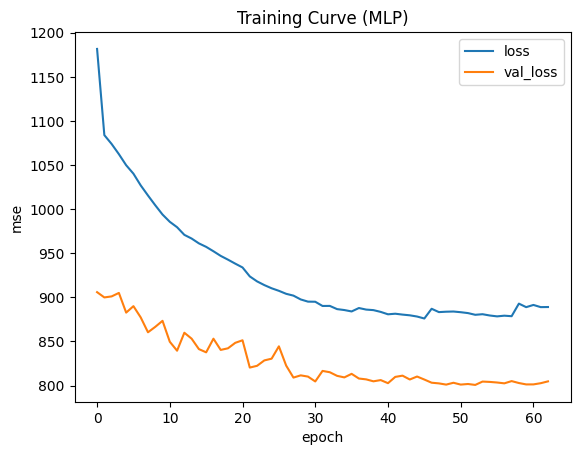

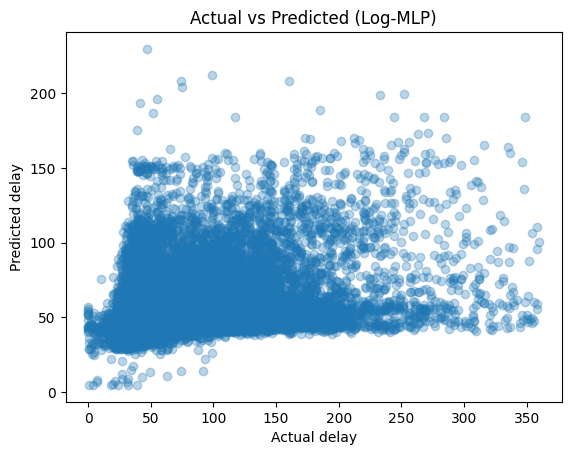

In [13]:
# =====================================================
# 1️⃣2️⃣ 학습 곡선 & 예측 산점도 (선택)
# =====================================================
import matplotlib.pyplot as plt

# 학습 곡선
plt.figure()
plt.plot(history.history.get("loss", []), label="loss")
plt.plot(history.history.get("val_loss", []), label="val_loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.title("Training Curve (MLP)")
plt.show()

# 예측 산점도 (로그 모델 결과 y_pred 사용)
plt.figure()
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.xlabel("Actual delay")
plt.ylabel("Predicted delay")
plt.title("Actual vs Predicted (Log-MLP)")
plt.show()


In [14]:
# =====================================================
# 1️⃣3️⃣ 예측 결과 확인
# =====================================================
result_df = pd.DataFrame({
    "actual_delay": y_test.values,
    "predicted_delay": y_pred
})

result_df.head(20)

,actual_delay,predicted_delay
0,37.0,43.181652
1,56.0,80.649193
2,40.0,52.349728
3,38.0,52.349728
4,9.0,33.632885
5,37.0,45.329437
6,70.0,45.329437
7,30.0,35.144073
8,146.0,76.914848
9,73.0,46.579273
